# HERA simulations

We use [`pyuvdata.UVBeam`](https://pyuvdata.readthedocs.io/en/latest/uvbeam.html#uvbeam) to calculate the `HERA` primary beam. There are a number of input data formats `UVBeam` can read. So far, `WODEN` has options to reads in `CST` text files, and a beam model `FITS` format. We'll use examples of both of these formats here, grabbing random examples from various `HERA`-related repositories. We'll look at the primary beam patters, and then run an end-to-end simulation using the `HERA` beam model.

## Primary beam patterns

The `UVBeam` wrapper inside `WODEN` is designed to read in `RA,Dec` coords from a sky catalogue, so let's make a grid of `az,za` and convert them to `RA,Dec` coords at the `HERA` location. We'll grab that from `pyuvdata`:

In [22]:
from pyuvdata.telescopes import known_telescope_location

##this is an astropy location object
location = known_telescope_location("HERA")

latitude = location.lat.value
longitude = location.lon.value
height = location.height.value
print(f"Latitude: {latitude} degrees")
print(f"Longitude: {longitude} degrees")
print(f"Height: {height} m")

Latitude: -30.72152612068926 degrees
Longitude: 21.42830382686301 degrees
Height: 1051.6900000007606 m


Make the `az/za` grid:

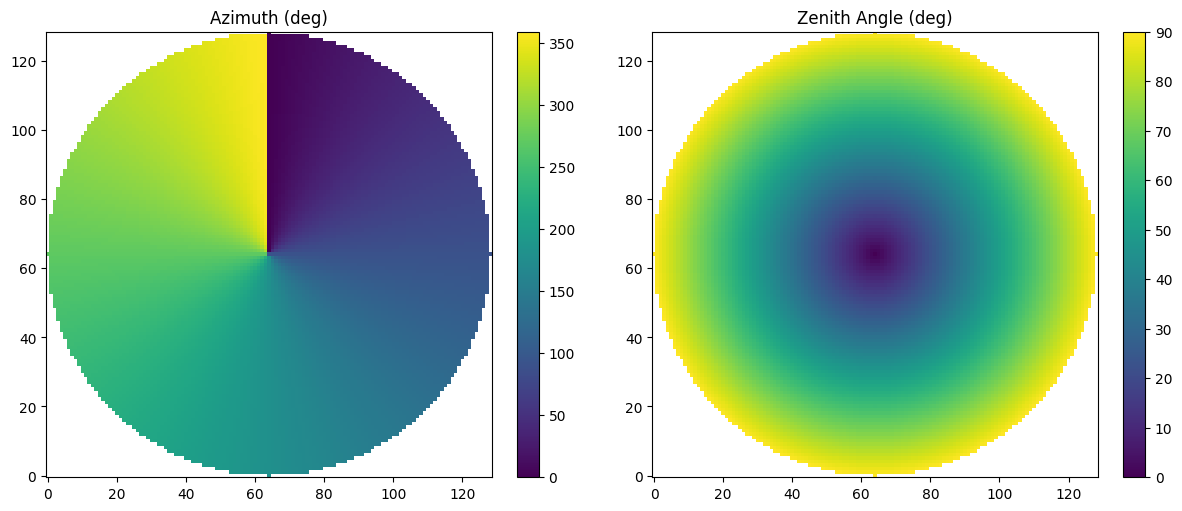

In [23]:
import numpy as np
import matplotlib.pyplot as plt

nside = 129
xrange = np.linspace(-1, 1, nside)
yrange = np.linspace(-1, 1, nside)
xcoords, ycoords = np.meshgrid(xrange, yrange)

za = np.sqrt(xcoords**2 + ycoords**2)*np.pi/2
az = np.pi/2 - np.arctan2(ycoords, xcoords)

az[az < 0] += 2*np.pi

below_horizon = za > np.pi/2
az[below_horizon] = np.nan
za[below_horizon] = np.nan

fig, axs = plt.subplots(1,2, figsize=(12, 5), layout='constrained') 

im = axs[0].imshow(np.degrees(az), origin='lower')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(np.degrees(za), origin='lower')
plt.colorbar(im, ax=axs[1])
axs[0].set_title('Azimuth (deg)')
axs[1].set_title('Zenith Angle (deg)')
plt.show()


Now convert to `RA,Dec` coords. For that we need an observing time. We'll be using the HERA phase 1 array layout, so let's pick a date in between Oct 2017 and April 2018, when phase 1 was being used ([Abdurashidova et al.](https://arxiv.org/pdf/2108.02263)). They also used three field centres. Let's pick F1 which is centred at `RA=2h`:

In [24]:
from astropy.time import Time

obstime = Time("2017-11-11T21:09:30", scale='utc', location=location)

lst_deg = obstime.sidereal_time('apparent').to_value('deg')
print(f"LST: {lst_deg} degrees")

LST: 30.001385332537474 degrees


An LST of 30 deg (two hours) is what we want so this is close enough. Righto, now we can convert the `az,za` grid to `RA,Dec` coords:

In [25]:
import erfa

has, decs = erfa.ae2hd(az, np.pi/2-za, np.radians(latitude))

ras = np.radians(lst_deg) - has

ras[ras < 0] += 2*np.pi  # wrap RA to [0, 2pi]

fig, axs = plt.subplots(1,2, figsize=(12, 5), layout='constrained') 

im = axs[0].imshow(np.degrees(ras), origin='lower')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(np.degrees(decs), origin='lower')
plt.colorbar(im, ax=axs[1])
axs[0].set_title('RA (deg)')
axs[1].set_title('Dec (deg)')
plt.show()

### CST text files
After some online sleuthing, you can find some old `CST` files in [Nicolas Fagnoni's Simulations repo](https://github.com/Nicolas-Fagnoni/Simulations). Let's download and unpack the 100 to 150 MHz files.

In [27]:
from glob import glob

files = glob("hera_beam/*.txt")

files.sort()


with open("hera_cst_4.9m_pattern_list.txt", "w") as f:

    for file in files:
        freq = file.split("_")[-1].split("MHz")[0]
        
        f.write(f"{file},{freq}\n")

In [ ]:
%%bash
# Download the HERA E-field pattern

mkdir -p hera_beam

wget "https://github.com/Nicolas-Fagnoni/Simulations/raw/refs/heads/master/Radiation%20patterns/Archive/E-field%20pattern%20-%20Rigging%20height%204.9%20m/HERA_4.9m_E-pattern_100-150MHz.zip" -O hera_beam/HERA_4.9m_E-pattern_100-150MHz.zip

unzip hera_beam/HERA_4.9m_E-pattern_100-150MHz.zip -d hera_beam

Beam pattern names come out with spaces in them, annoying for Linux systems, so I'm going to rename them here


In [ ]:
from subprocess import call
from glob import glob

files = glob("hera_beam/*.txt")
    
for ind in range(len(files)):
    cmd = f"mv '{files[ind]}' {''.join(files[ind].split(' '))}"
    # print(cmd)
    call(cmd, shell=True)

First of all, we make a `UVBeam` object from the `CST` text files. To do that, need a list of all the filenames, and an array of associated frequencies. 

In [30]:
from wodenpy.primary_beam.use_uvbeam import setup_HERA_uvbeams_from_CST

cst_files = sorted(glob("hera_beam/*.txt"))
cst_freqs = [float(file.split("_")[-1].split("MHz")[0])*1e+6 for file in cst_files]

uvbeam_objs = setup_HERA_uvbeams_from_CST(cst_files, cst_freqs)

Finally let calculate the beam pattern. We'll do two time steps and two frequencies. The `HERA` beam is zenith-locked. As we're feeding in `RA,Dec` coords, we should see the beam pattern centred in the first time step, and then shifted away from centred in the second time step.

In [31]:
from wodenpy.primary_beam.use_uvbeam import run_uvbeam

##no need to do precession for simple test here
j2000_latitudes = np.radians([latitude]*2)
##add an extra 2 hours to lst for second time step
j2000_lsts = np.radians([lst_deg, lst_deg + 60.0])

freqs = np.array([100e+6, 150e+6])

all_jones_cst = run_uvbeam(uvbeam_objs, ras.flatten(), decs.flatten(),
                           j2000_latitudes, j2000_lsts,
                           freqs, iau_order=True, parallactic_rotate=True)

invalid value encountered in hd2ae


Let's make some beam plots. I'm going to `log` the amplitudes to make the pattern more visible. `run_uvbeam` has been written to make outputs that fit into the `wodenpy` beam framework, which can handle unique beam models per station. The beam models I'm using here are only for one station, so if you see me setting `station=0`, that's why.

In [32]:
def plot_jones(all_jones, time_ind, lsts, freq_ind, freqs, title, nside):
    
    fig, axs = plt.subplots(4, 4, figsize=(12, 10), layout='constrained')
    
    station_ind=0
    
    gx = all_jones[0, time_ind, freq_ind, :, 0, 0]
    Dx = all_jones[0, time_ind, freq_ind, :, 1, 0]
    Dy = all_jones[0, time_ind, freq_ind, :, 0, 1]
    gy = all_jones[0, time_ind, freq_ind, :, 1, 1]
    
    ax = 0
    for pol, label in zip([gx, Dx, Dy, gy], ['gx', 'Dx', 'Dy', 'gy']):
        
        pol = pol.reshape((nside, nside))
        
        im = axs[ax, 0].imshow(np.real(pol), origin='lower')
        axs[ax, 0].set_title(f'Real {label}')
        plt.colorbar(im, ax=axs[ax, 0])
        im = axs[ax, 1].imshow(np.imag(pol), origin='lower')
        axs[ax, 1].set_title(f'Imag {label}')
        plt.colorbar(im, ax=axs[ax, 1])
        im = axs[ax, 2].imshow(np.log10(np.abs(pol)), origin='lower')
        axs[ax, 2].set_title(f'log 10 abs {label}')
        plt.colorbar(im, ax=axs[ax, 2])
        im = axs[ax, 3].imshow(np.angle(pol), origin='lower')
        axs[ax, 3].set_title(f'Phase {label}')
        plt.colorbar(im, ax=axs[ax, 3])
        
        ax += 1
        
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.suptitle(f'{title} {freqs[freq_ind]/1e+6:.1f} MHz, LST {np.degrees(lsts[time_ind]):.1f} deg')
    plt.show()
    
plot_jones(all_jones_cst, 0, j2000_lsts, 0, freqs, 'CST', nside)

Looks pretty single dipole-like. I've set `iau_order=True` as internally `WODEN` uses the IAU conventions. This means `gx` in above is the gain term for the north-south dipole. That means `gx` should be more sensitive to the east-west. The beam pattern does look elongated in the east-west direction, and vice-versa for `gy`, so the polarisations are behaving as expected. Let's check the beam gets smaller at higher frequencies, and moves with time.  

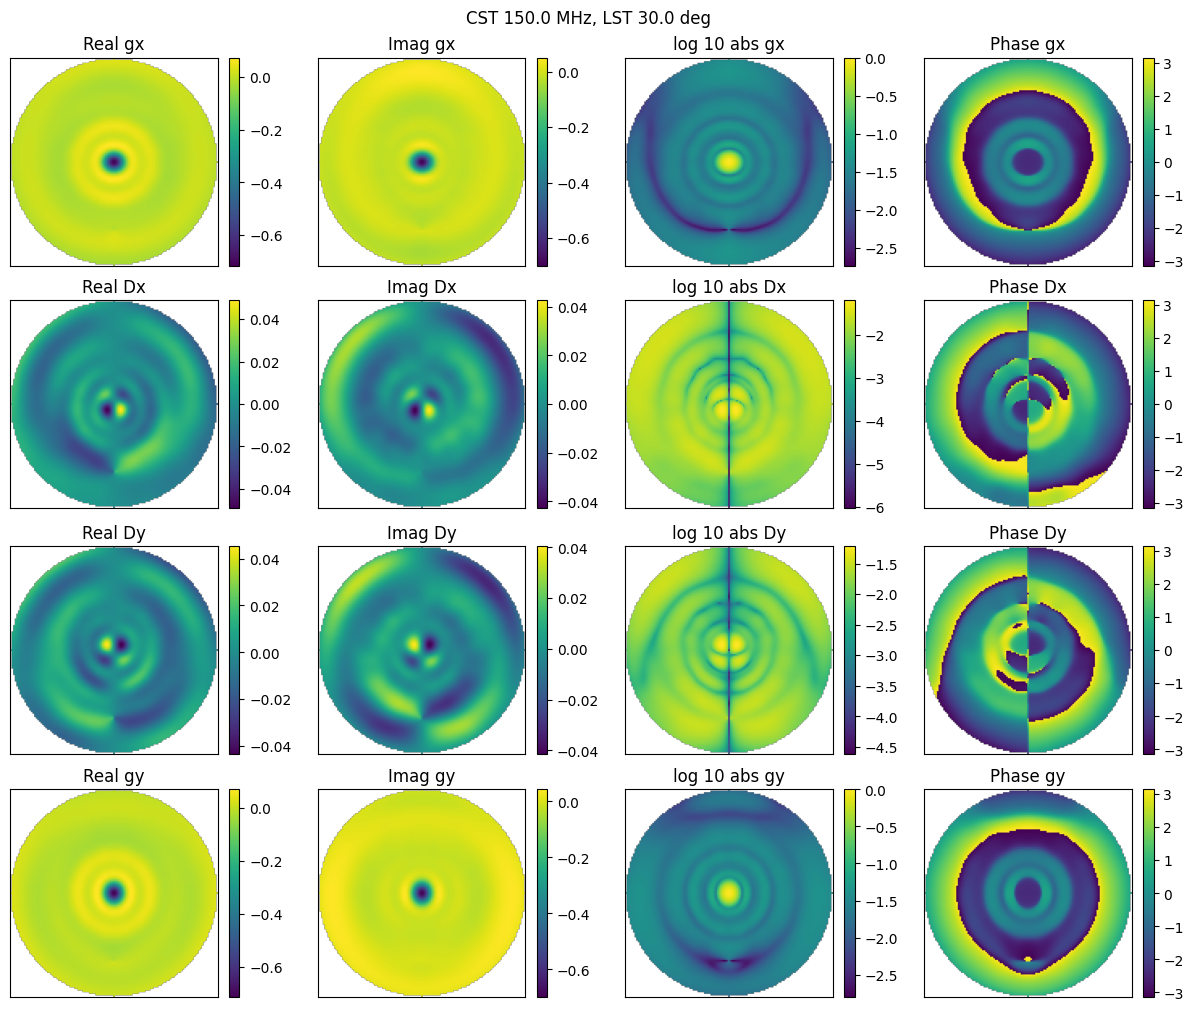

In [33]:
plot_jones(all_jones_cst, 0, j2000_lsts, 1, freqs, 'CST', nside)

In [34]:
plot_jones(all_jones_cst, 1, j2000_lsts, 0, freqs, 'CST', nside)

Indeed it does, so things are looking good. Now let's try the `FITS` format.

### FITS beam file
We'll do the same again but with a beam `FITS` format. Again, I've stalked `HERA`-repos, and found a `FITS` beam file in [mativs](https://github.com/HERA-Team/matvis/tree/main/src/matvis/data) which we can download.

In [ ]:
%%bash

wget "https://github.com/HERA-Team/matvis/raw/refs/heads/main/src/matvis/data/NF_HERA_Dipole_small.fits" -O NF_HERA_Dipole_small.fits

In [36]:
from wodenpy.primary_beam.use_uvbeam import setup_HERA_uvbeams_from_single_file

uvbeam_fits_objs = setup_HERA_uvbeams_from_single_file("NF_HERA_Dipole_small.fits")

print(uvbeam_fits_objs[0].freq_array)

[1.00e+08 1.01e+08]


Unforntunately, this only contains two frequencies. By default, `UVBeam` wants to interpolate over frequencies, and the default interp needs three at a minimum. The `WODEN` wrapper will just switch interpolation off if there's <3 frequencies. At least we can compare the beam patterns at 100MHz.

In [37]:
all_jones_fits = run_uvbeam(uvbeam_fits_objs, ras.flatten(), decs.flatten(),
                           j2000_latitudes, j2000_lsts,
                           freqs, iau_order=True, parallactic_rotate=True)

2025-06-02 11:15:17 - WARNING - Number of frequencies in the UVBeam object is less than 3.
WODEN will proceed, but will switch off frequency interpolation.
UVBeam needs at least three frequencies to perform default interpolation.
Further warnings of this type will be suppressed.

2025-06-02 11:15:17 - WARNING - Number of frequencies in the UVBeam object is less than 3.
WODEN will proceed, but will switch off frequency interpolation.
UVBeam needs at least three frequencies to perform default interpolation.
Further warnings of this type will be suppressed.

2025-06-02 11:15:17 - WARNING - Number of frequencies in the UVBeam object is less than 3.
WODEN will proceed, but will switch off frequency interpolation.
UVBeam needs at least three frequencies to perform default interpolation.
Further warnings of this type will be suppressed.

2025-06-02 11:15:17 - WARNING - Number of frequencies in the UVBeam object is less than 3.
WODEN will proceed, but will switch off frequency interpolation.
U

We can at least check that the beam moves with time; obviously it won't change with frequency.

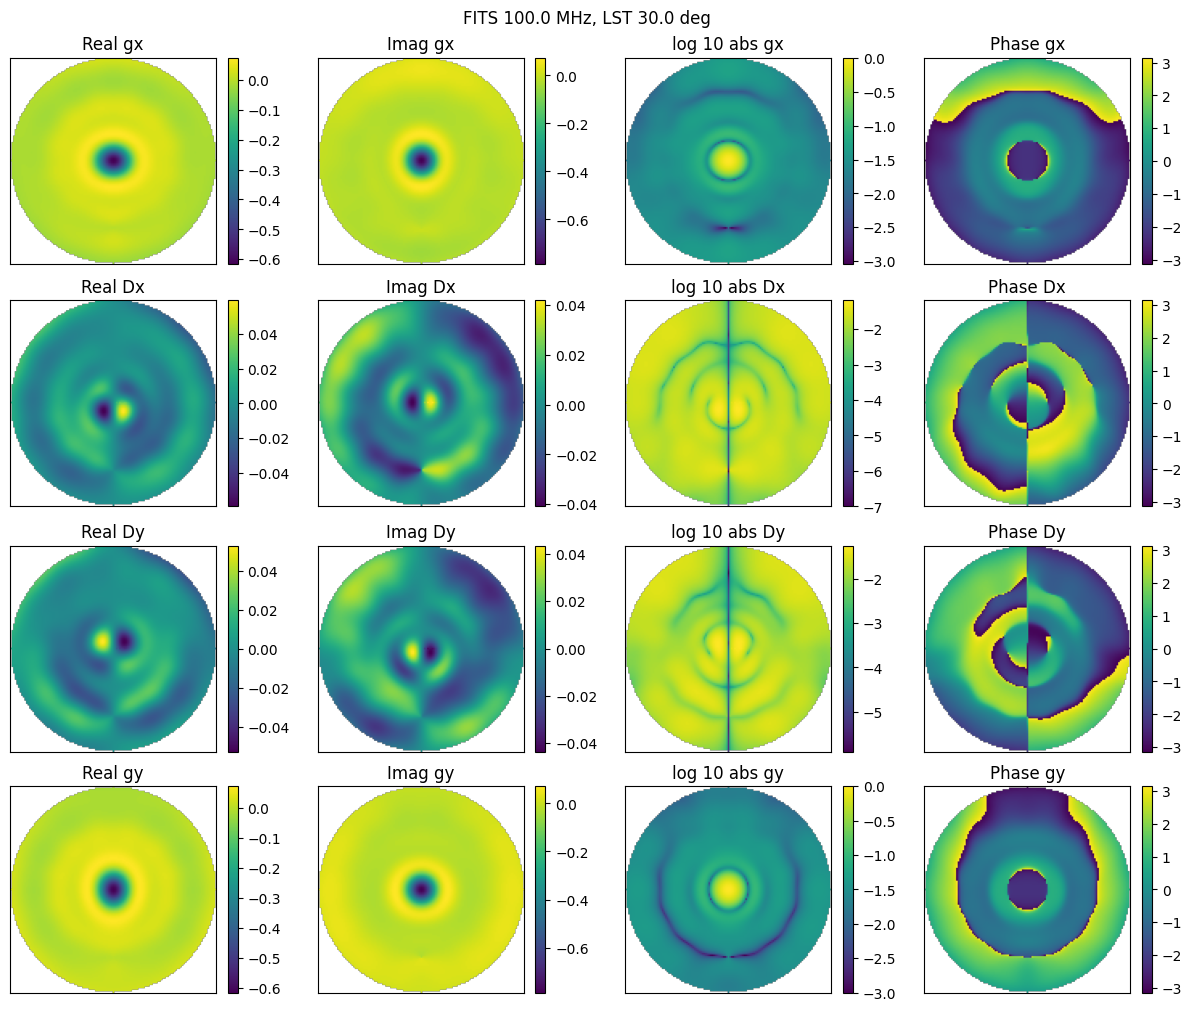

In [38]:
plot_jones(all_jones_fits, 0, j2000_lsts, 0, freqs, 'FITS', nside)

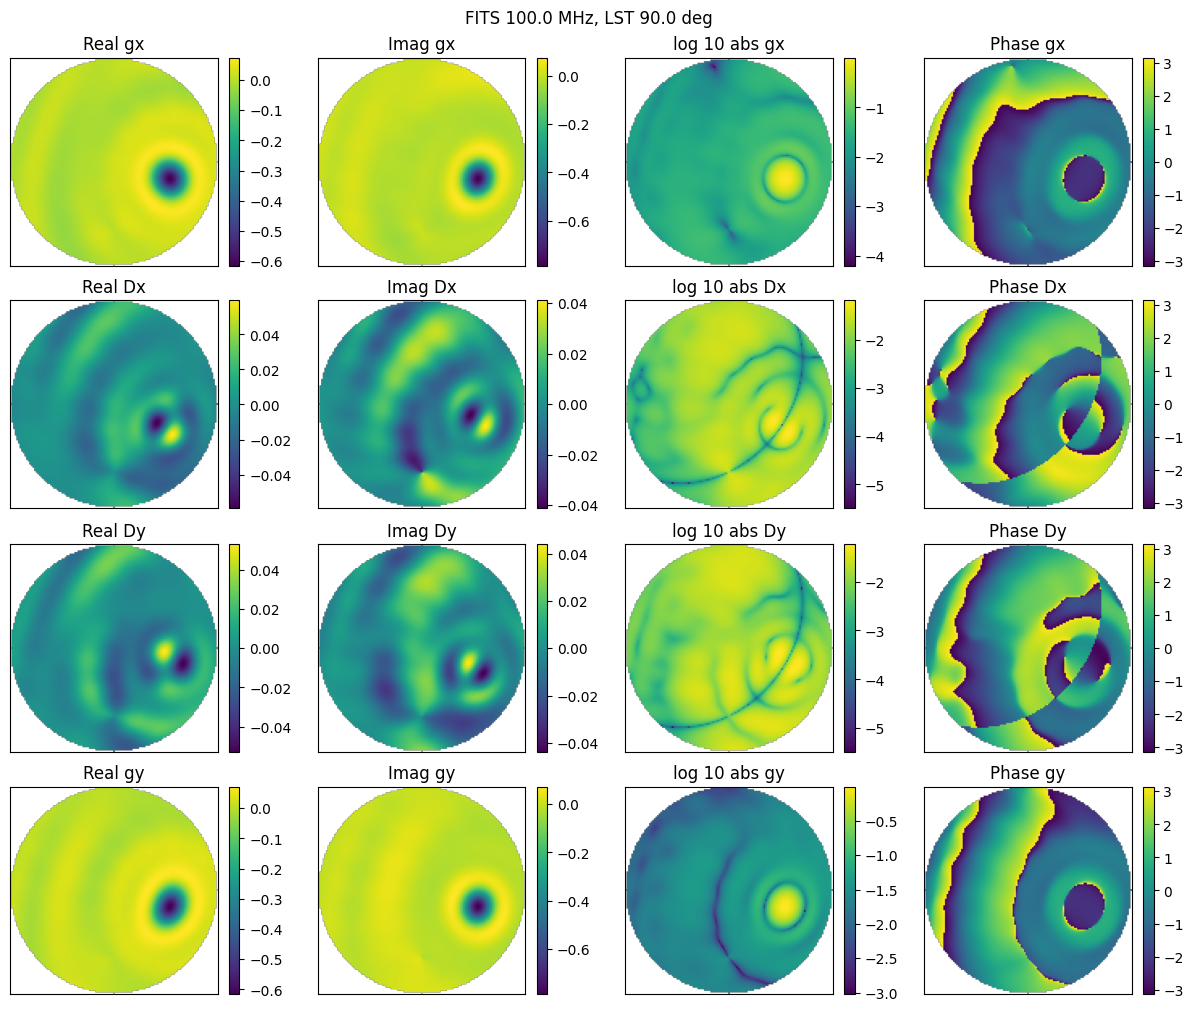

In [39]:
plot_jones(all_jones_fits, 1, j2000_lsts, 0, freqs, 'FITS', nside)

Let's compare the gains of the two models at 100MHz to convince ourselves we're plottings two different models.

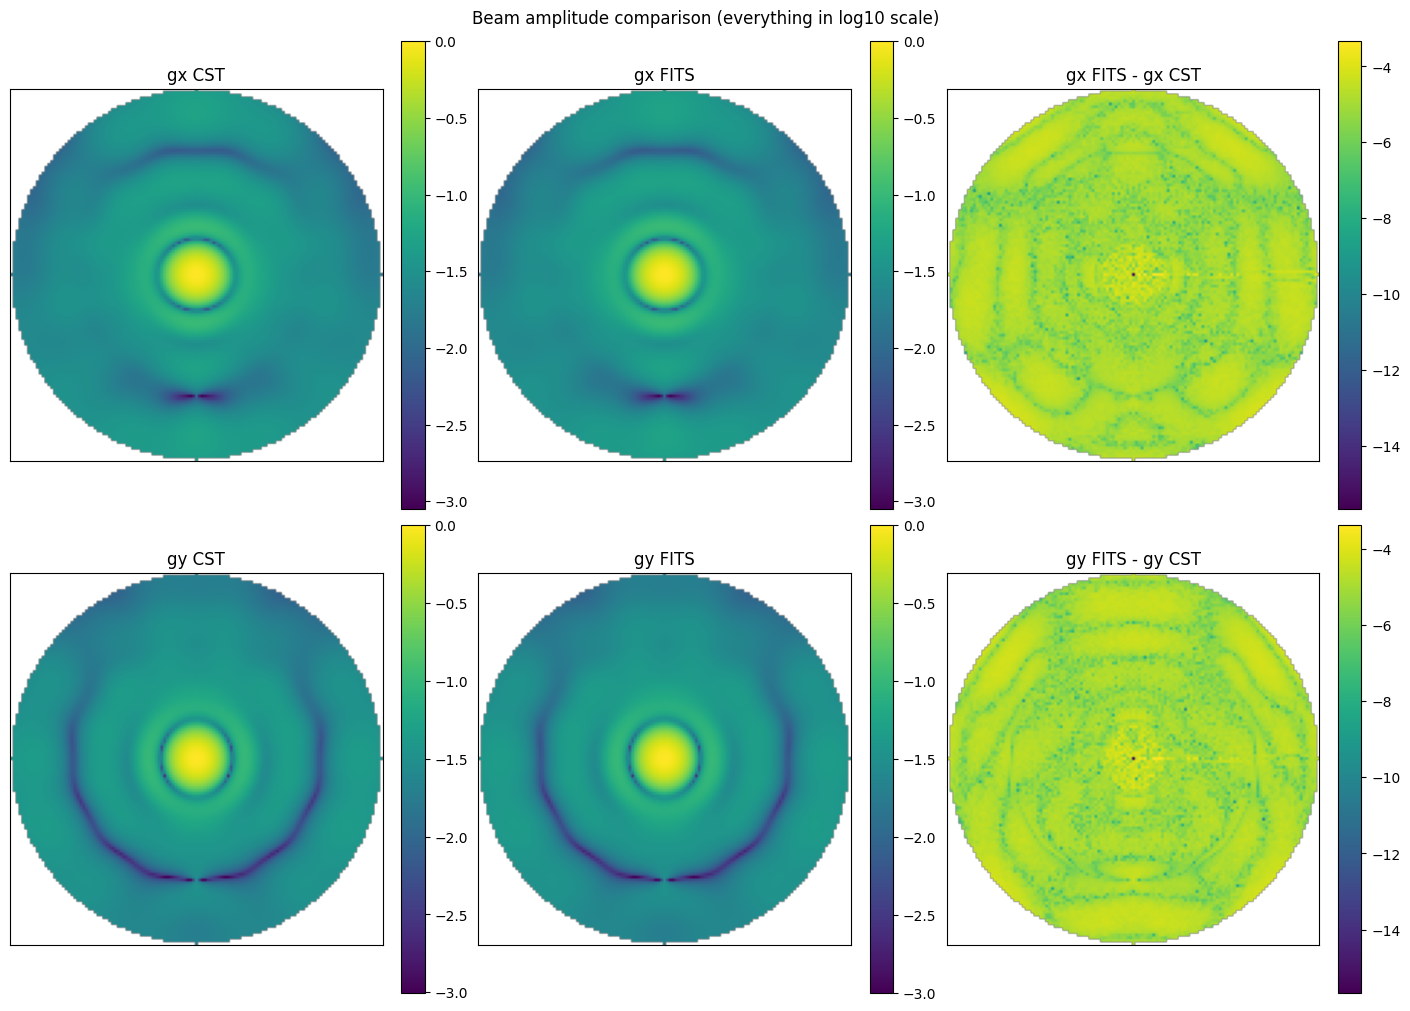

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10), layout='constrained')
    
station_ind=0
time_ind = 0
freq_ind = 0

gx_cst = all_jones_cst[station_ind, time_ind, freq_ind, :, 0, 0]
gx_fits = all_jones_fits[station_ind, time_ind, freq_ind, :, 0, 0]

gy_cst = all_jones_cst[station_ind, time_ind, freq_ind, :, 1, 1]
gy_fits = all_jones_fits[station_ind, time_ind, freq_ind, :, 1, 1]


for ind, pol, label in zip(range(6), [gx_cst, gx_fits, np.abs(gx_fits) - np.abs(gx_cst),
                                      gy_cst, gy_fits, np.abs(gy_fits) - np.abs(gy_cst)],
                                     ['gx CST', 'gx FITS', 'gx FITS - gx CST',
                                      'gy CST', 'gy FITS', 'gy FITS - gy CST']):
    
    pol = pol.reshape((nside, nside))
    
    col = ind % 3
    row = ind // 3
    im = axs[row, col].imshow(np.log10(np.abs(pol)), origin='lower')
    # im = axs[row, col].imshow(np.abs(pol), origin='lower')
    axs[row, col].set_title(f'{label}')
    plt.colorbar(im, ax=axs[row, col])
    
    
    
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.suptitle(f'Beam amplitude comparison (everything in log10 scale)')
plt.show()

Huh well maybe these are actually the same model, just stored in different formats. There *is* a slight difference, so at least we're defo reading in two different things, and they both work.

## End-to-end simulation
Now let's run an end-to-end simulation using the `HERA` beam model. We'll use the `CST` text files, as they have more frequencies than the `FITS` file. I'm also going to just use the Aussie MWA sky model, as that's already in the `WODEN` format, and `HERA` sits at almost the same latitude as the `MWA`.

### Array layouts
I need an array lay however, so once again let's get something off the interwebs:

In [41]:
import pandas as pd

url = "https://raw.githubusercontent.com/HERA-Team/hera_sim/main/src/hera_sim/data/tutorials_data/visibility_simulator/antenna_layout_hera_phase1.csv"
df = pd.read_csv(url, delimiter="\t")
df.head()

Name  Number  BeamID           E           N         U
0   ANT0       0     0.0 -105.035302 -110.722053  0.938171
1   ANT1       1     0.0  -90.427459 -110.666264  0.928396
2   ANT2       2     0.0  -75.819616 -110.610476  0.918587
3  ANT11      11     0.0 -112.387519  -98.103144  0.788253
4  ANT12      12     0.0  -97.779676  -98.047355  0.718495

In [42]:
import numpy as np

num_ants = df.shape[0]

enh = np.empty((num_ants, 3), dtype=float)

enh[:, 0] = df["E"].values
enh[:, 1] = df["N"].values
enh[:, 2] = df["U"].values

Let's have a look-see.

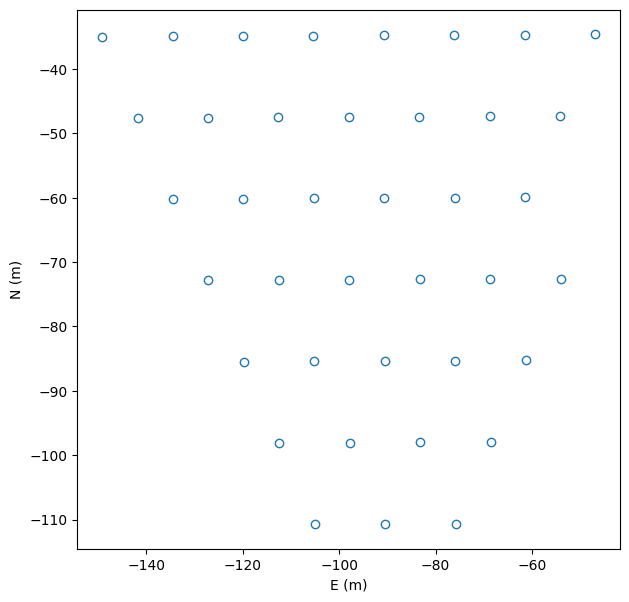

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.plot(enh[:, 0], enh[:, 1], 'o', mfc='none', label='HERA Phase 1 Antennas')

ax.set_xlabel('E (m)')
ax.set_ylabel('N (m)')

plt.show()

Save it to a format that `WODEN` can read.

In [44]:
np.savetxt('hera_phase1_antenna_layout.txt', enh,  fmt='%f', delimiter=' ')

Let's make a version with some outrigger dishes so we can make some better images from the resultant simulation.

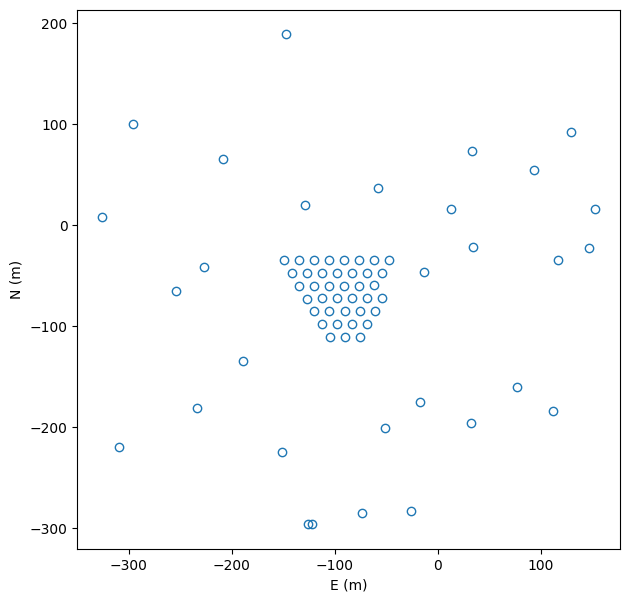

In [45]:
num_extra_ants = 30

enh_enhanced = np.zeros((num_ants + num_extra_ants, 3), dtype=float)
# # print(enh_enhanced.shape, enh.shape)

enh_enhanced[num_extra_ants:, :] = enh

east_mid = np.mean(enh[:, 0])
north_mid = np.mean(enh[:, 1])

radius = np.random.uniform(70, 300, num_extra_ants)
theta = np.random.uniform(0, 2 * np.pi, num_extra_ants)

enh_enhanced[:num_extra_ants, 0] = east_mid + radius * np.cos(theta)
enh_enhanced[:num_extra_ants, 1] = north_mid + radius * np.sin(theta)

            
np.savetxt('hera_phase1_antenna_layout_with_out-riggers.txt', enh_enhanced,  fmt='%f', delimiter=' ')

fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.plot(enh_enhanced[:, 0], enh_enhanced[:, 1], 'o', mfc='none', label='HERA Phase 1 Antennas + outriggers')

ax.set_xlabel('E (m)')
ax.set_ylabel('N (m)')

plt.show()

To make things tidy when running `run_woden.py`, I've setup the function to read in the `CST` files path and associated frequencies from a single csv file. Let's write that now:

In [46]:
with open("hera_cst_4.9m_pattern_list.csv", "w") as f:
    for freq in range(100, 151, 1):
        f.write(f"hera_beam/HERA_4.9m_E-pattern_{freq}MHz.txt,{freq}e+6\n")


Now we need the sky model, so let's download that:

In [ ]:
%%bash

wget "https://github.com/JLBLine/srclists/raw/refs/heads/master/srclist_pumav3_EoR0LoBES_EoR1pietro_CenA-GP_2023-11-07.fits" -O srclist_pumav3_EoR0LoBES_EoR1pietro_CenA-GP_2023-11-07.fits

Now we have everything we need, let's run a simulation. I'll use frequency and time settings as specified in `Abdurashidova et al.`. I'm going to run the simulation using the outrigger dishes to make a better image.

In [48]:
%%bash

run_woden.py \
    --ra0=30.0 --dec0=-30.0 \
    --num_freq_channels=10 --num_time_steps=10 \
    --date=2017-11-11T21:09:30 --lowest_channel_freq=100e+6 \
    --freq_res=97.66e+3 --time_res=10.7 \
    --cat_filename=srclist_pumav3_EoR0LoBES_EoR1pietro_CenA-GP_2023-11-07.fits \
    --array_layout=hera_phase1_antenna_layout_with_out-riggers.txt \
    --band_nums=1 \
    --output_uvfits_prepend=woden_HERA+outriggers_F1 \
    --primary_beam=uvbeam_HERA \
    --num_threads=1 \
    --cst_file_list=hera_cst_4.9m_pattern_list.csv

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-06-02 11:15:31 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-06-02 11:15:31 - INFO - Input arguments after parsing:
                             	Phase centre: 30.00000, -30.00000 deg
                             	Array central latitude: -30.722 deg
                             	Array central longitude: 21.428 deg
               

Righto, we have a simulation! Let's make an image

In [49]:
%%bash

woden_uv2ms.py \
  --uvfits_prepend=woden_HERA+outriggers_F1_band \
  --band_nums=1

/home/jack-line/software/WODEN_dev/woden_dev/bin/woden_uv2ms.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')
The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).


In [50]:
%%bash 

wsclean -name woden_HERA+outriggers_F1 -size 2048 2048 -niter 3000 \
  -auto-threshold 0.5 -auto-mask 3 -pol I -multiscale \
  -weight uniform -scale 0.03 -j 12 -mgain 0.85 -no-update-model-required  \
  woden_HERA+outriggers_F1_band*.ms 


WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-101 (10)
Reordering woden_HERA+outriggers_F1_band01.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for uniform weighting...
Opening reordered part 0 spw 0 for woden_HERA+outriggers_F1_band01.ms
Detected 62.7 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for woden_HERA+outriggers_F1_band01.ms
Determining min and max w & theoretical beam size... DONE (w=[2.0881e-05:2.37788] lambdas, maxuvw=181.324 lambda)
Theoretic

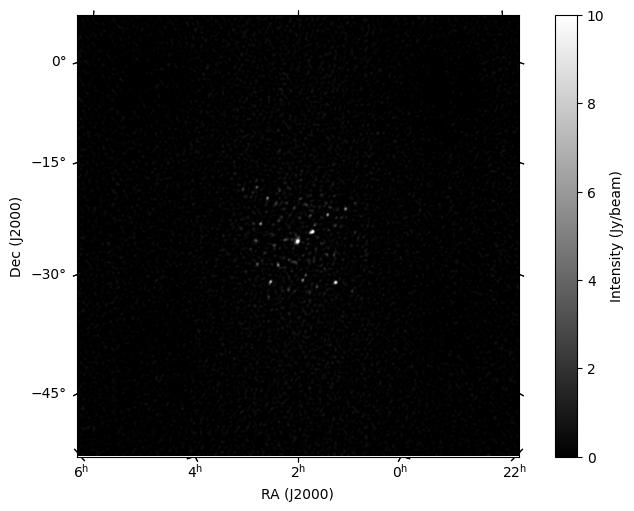

In [51]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt

# Load the WSClean output image
image_file = 'woden_HERA+outriggers_F1-image.fits'
with fits.open(image_file) as hdul:
    image_data = np.squeeze(hdul[0].data)
    header = hdul[0].header
    
wcs = WCS(header).celestial
    
# Display the image
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout='constrained', subplot_kw={'projection': wcs})
im = ax.imshow(image_data, origin='lower', cmap='gray', vmin=0, vmax=10)
plt.colorbar(im, label='Intensity (Jy/beam)')
ax.set_xlabel('RA (J2000)')
ax.set_ylabel('Dec (J2000)')
plt.show()

Lovely, we have some blobs on the sky. Let's do the simulation again, but this time without the outrigger dishes. Obviously `HERA` isn't an imaging array, but we'll make an image anyways.

In [52]:
%%bash

run_woden.py \
    --ra0=30.0 --dec0=-30.0 \
    --num_freq_channels=10 --num_time_steps=10 \
    --date=2017-11-11T21:09:30 --lowest_channel_freq=100e+6 \
    --freq_res=97.66e+3 --time_res=10.7 \
    --cat_filename=srclist_pumav3_EoR0LoBES_EoR1pietro_CenA-GP_2023-11-07.fits \
    --array_layout=hera_phase1_antenna_layout.txt \
    --band_nums=1 \
    --output_uvfits_prepend=woden_HERA_F1 \
    --primary_beam=uvbeam_HERA \
    --num_threads=1 \
    --cst_file_list=hera_cst_4.9m_pattern_list.csv

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-06-02 11:22:15 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-06-02 11:22:15 - INFO - Input arguments after parsing:
                             	Phase centre: 30.00000, -30.00000 deg
                             	Array central latitude: -30.722 deg
                             	Array central longitude: 21.428 deg
               

In [53]:
%%bash

woden_uv2ms.py \
  --uvfits_prepend=woden_HERA_F1_band \
  --band_nums=1
  
wsclean -name woden_HERA_F1 -size 2048 2048 -niter 0 \
  -auto-threshold 0.5 -auto-mask 3 -pol I -multiscale \
  -weight uniform -scale 0.03 -j 12 -mgain 0.85 -no-update-model-required  \
  woden_HERA_F1_band*.ms 

/home/jack-line/software/WODEN_dev/woden_dev/bin/woden_uv2ms.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')
The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).



WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-101 (10)
Reordering woden_HERA_F1_band01.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing image ==
Precalculating weights for uniform weighting...
Opening reordered part 0 spw 0 for woden_HERA_F1_band01.ms
Detected 62.7 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for woden_HERA_F1_band01.ms
Determining min and max w & theoretical beam size... DONE (w=[2.0881e-05:0.22119] lambdas, maxuvw=35.4462 lambda)
Theoretic beam = 96.98'
Minimal inversio

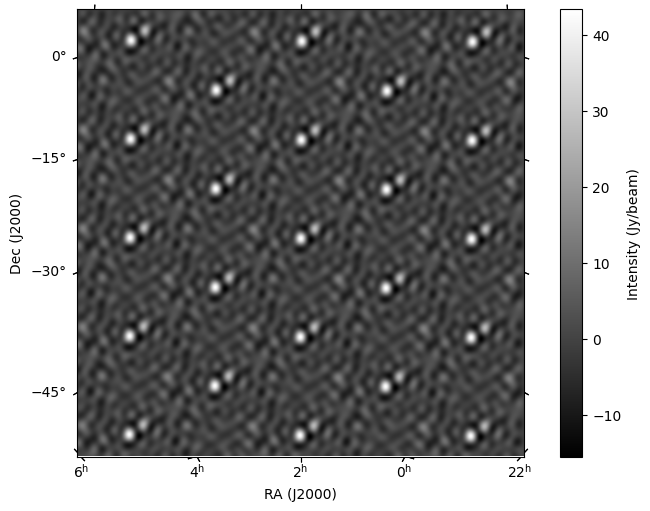

In [54]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt

# Load the WSClean output image
image_file = 'woden_HERA_F1-image.fits'
with fits.open(image_file) as hdul:
    image_data = np.squeeze(hdul[0].data)
    header = hdul[0].header
    
wcs = WCS(header).celestial
    
# Display the image
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout='constrained', subplot_kw={'projection': wcs})
im = ax.imshow(image_data, origin='lower', cmap='gray')
plt.colorbar(im, label='Intensity (Jy/beam)')
ax.set_xlabel('RA (J2000)')
ax.set_ylabel('Dec (J2000)')
plt.show()

Unsurprisingly, this image is bad. But it makes sense at least, so there you go.